In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pandas as pd
import numpy as np


import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 读取数据集

In [2]:

df = pd.read_csv('医疗费用预测insurance.csv')
with open("insuranceCfg.json", "r", encoding="utf-8") as f:
        cfg = json.load(f)
print("cfg:",cfg)

#编码
df['sex'] = df['sex'].map({'female':0,'male':1})  
df['smoker'] = df['smoker'].map({'no':0,'yes':1})
df['region'] = df['region'].map({'northeast':0,'northwest':1,'southeast':2,'southwest':3})


features = df.iloc[:, :-1] # 特征
features = torch.tensor(features.values,dtype=torch.float32)

labels = df.iloc[:,-1]  # 标签
labels = torch.tensor(labels,dtype=torch.float32)


#归一化
# 特征和标签归一化
features_tensor = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
labels_tensor = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32)

# 计算归一化参数
feature_min = features_tensor.min(dim=0).values
feature_max = features_tensor.max(dim=0).values
label_min = labels_tensor.min()
label_max = labels_tensor.max()

# 应用归一化
features = (features_tensor - feature_min) / (feature_max - feature_min + 1e-8)
labels = (labels_tensor - label_min) / (label_max - label_min + 1e-8)
labels = labels.view(-1, 1)  # 确保形状为 [n_samples, 1]


class insuranceDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
batch_Size = int(cfg['batch_Size'])  #32


dataset = insuranceDataset(features, labels)
train_loader = DataLoader(dataset, batch_size=batch_Size, shuffle=True)





cfg: {'batch_Size': '32', 'epochs': '300', 'lr': ['0.0001', '0.001', '0.01', '0.1'], 'input_size': '6', 'hidden_size': '16', 'output_size': '1', 'patience': '20000'}


### 模型搭建

In [3]:
class insuranceModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(insuranceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    


### 训练

In [4]:
input_size, hidden_size, output_size = int(cfg['input_size']), int(cfg['hidden_size']), int(cfg['output_size'])
model = insuranceModel(input_size, hidden_size, output_size).to(device)  # input_size=6, hidden_size=4, output_size=1
criterion = nn.MSELoss()

cfg_lr = cfg['lr'] # List

train_loss_history_sum = []

for i in range(len(cfg_lr)):

    optimizer = torch.optim.Adam(model.parameters(), lr=float(cfg_lr[i]))

    # 初始化记录
    
    best_loss = float('inf')

    train_loss_history = []
    patience = int(cfg["patience"])
    counter = 0


    for epoch in range(int(cfg['epochs'])):
        epoch_loss = 0.0
        model.train()
        
        for i, (features, labels) in enumerate(train_loader):
            features = features.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if (i+1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, cfg['epochs'], i+1, len(train_loader), loss.item()))
        
        avg_loss = epoch_loss / len(train_loader)
        train_loss_history.append(avg_loss)
        

        # 保存最佳模型
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'loss': avg_loss
            }, 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break
        
        # 打印每个epoch的平均损失
        print(f'Epoch {epoch+1} Average Loss: {avg_loss:.4f}')

    train_loss_history_sum.append(train_loss_history)

print('Finished Training!')

e:\anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/300], Step [10/42], Loss: 0.0522
Epoch [1/300], Step [20/42], Loss: 0.0459
Epoch [1/300], Step [30/42], Loss: 0.0356
Epoch [1/300], Step [40/42], Loss: 0.0313
Epoch 1 Average Loss: 0.0419
Epoch [2/300], Step [10/42], Loss: 0.0238
Epoch [2/300], Step [20/42], Loss: 0.0498
Epoch [2/300], Step [30/42], Loss: 0.0344
Epoch [2/300], Step [40/42], Loss: 0.0502
Epoch 2 Average Loss: 0.0396
Epoch [3/300], Step [10/42], Loss: 0.0287
Epoch [3/300], Step [20/42], Loss: 0.0310
Epoch [3/300], Step [30/42], Loss: 0.0373
Epoch [3/300], Step [40/42], Loss: 0.0347
Epoch 3 Average Loss: 0.0377
Epoch [4/300], Step [10/42], Loss: 0.0258
Epoch [4/300], Step [20/42], Loss: 0.0395
Epoch [4/300], Step [30/42], Loss: 0.0432
Epoch [4/300], Step [40/42], Loss: 0.0480
Epoch 4 Average Loss: 0.0362
Epoch [5/300], Step [10/42], Loss: 0.0305
Epoch [5/300], Step [20/42], Loss: 0.0201
Epoch [5/300], Step [30/42], Loss: 0.0278
Epoch [5/300], Step [40/42], Loss: 0.0216
Epoch 5 Average Loss: 0.0349
Epoch [6/300], 

### 训练过程可视化

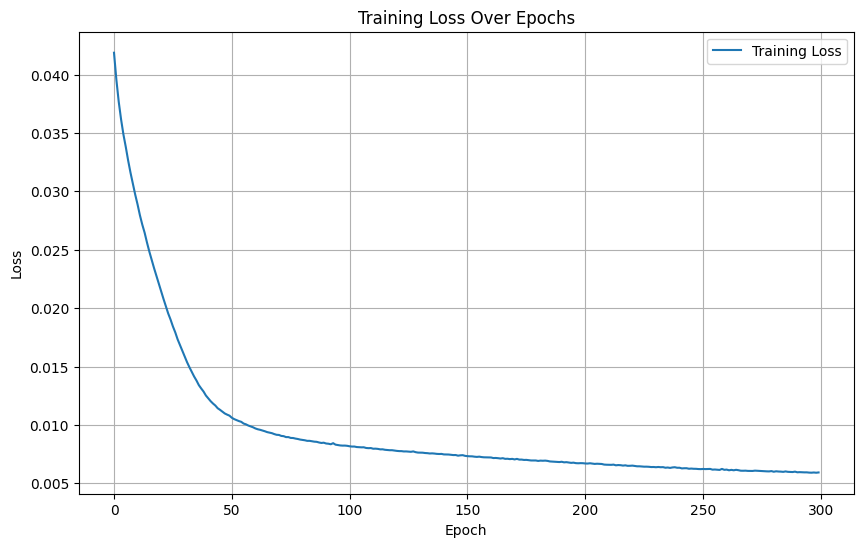

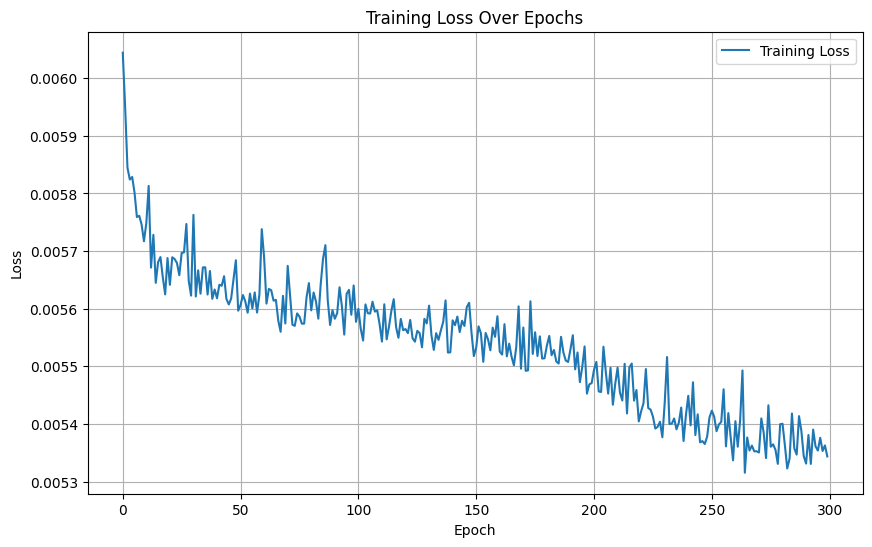

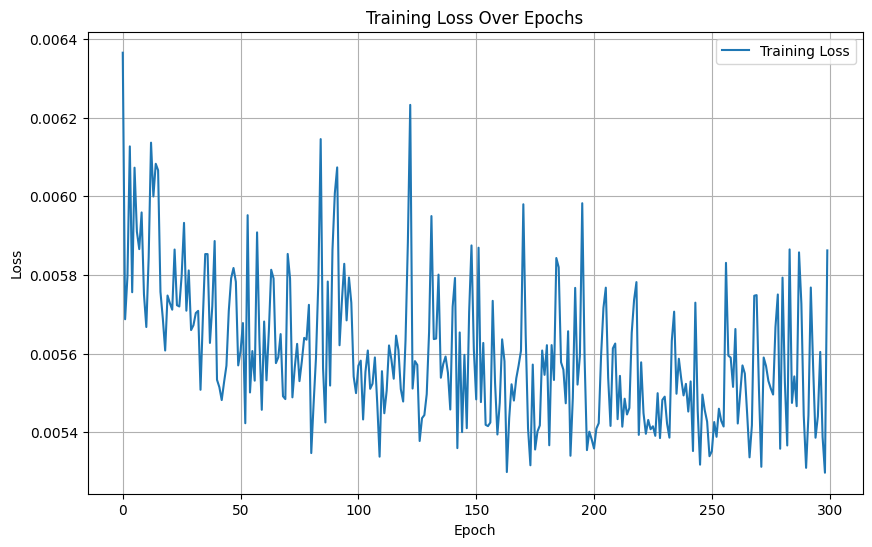

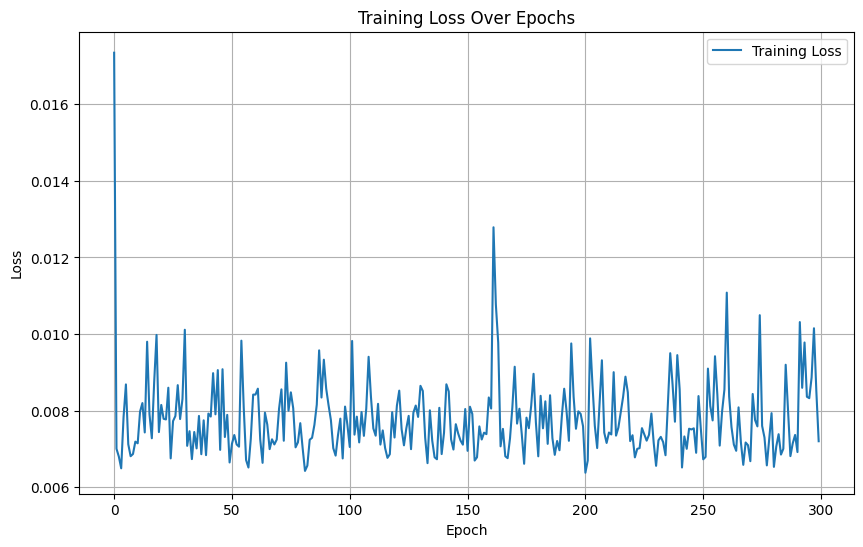

In [5]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

for i in range(len(cfg_lr)):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history_sum[i], label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'training_lr_{cfg_lr[i]}.png')